In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning imports - CLASSIFICATION ONLY
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("MOTIVATION PREDICTION MODEL")
print("=" * 60)
print("Predicting Motivation scores using behavioral features")
print("Target: Motivation (Average of PostSE and PostMAP)")
print("Features: MAP-specific and SE-specific behavioral patterns")
print("=" * 60)


MOTIVATION PREDICTION MODEL
Predicting Motivation scores using behavioral features
Target: Motivation (Average of PostSE and PostMAP)
Features: MAP-specific and SE-specific behavioral patterns


# Training Data Preprocessing

In [ ]:
df_main = pd.read_csv("./raw_data/training_set_with_formatted_time.csv")
df_ws = pd.read_csv("./raw_data/workspace_summary_train.csv")
df_scores = pd.read_csv("./raw_data/student_scores_train.csv")

df_main.drop_duplicates(inplace=True)
df_ws.drop_duplicates(inplace=True)
df_scores.drop_duplicates(inplace=True)

In [ ]:
# Remove unnecessary columns
df_main.drop(columns=['CF..Anon.School.Id.', 'CF..Anon.Class.Id.', 'Time', 'formatted_time'], inplace=True)

# Remove rows containing 'OK_AMBIGUOUS'
df_main = df_main[df_main['Outcome'] != 'OK_AMBIGUOUS']

df_main.sort_values(by=['Anon.Student.Id', 'datetime'], inplace=True)

df_main['datetime'] = pd.to_datetime(
    df_main['datetime'],
    infer_datetime_format=True,
    errors='coerce'       # turns invalid parses into NaT
)

# Generate time steps
df_main['time_step'] = df_main.groupby('Anon.Student.Id')['datetime'].rank(method='first') - 1 

In [ ]:
df_main.to_csv('preprocessed_data/df_main_allws.csv', index=False)
df_ws.to_csv('preprocessed_data/df_ws_allws.csv', index=False)

In [ ]:
workspace_ids_to_remove = [
    'worksheet_grapher_a1_lin_mod_mult_rep',
    'equation_line_2',
    'analyzing_models_2step_rationals',
    'multiple_representations_of_linear_functions',
    'worksheet_grapher_a1_slope_intercept_integer',
    'worksheet_grapher_a1_slope_intercept_decimal',
    'connecting_slope_intercept_and_point_slope_forms',
    'equation_line_1',
    'equation_line_3',
    'worksheet_grapher_a1_mod_initial_plus_point',
    'worksheet_grapher_a1_mod_two_points',
    'modeling_linear_equations_in_standard_form',
    'graph_setup_linear_equation-1',
    'graph_setup_linear_equation-2',
    'classifying_relations_and_functions',
    'introduction_to_functions',
    'graphs_of_functions',
    'graphs_of_functions-1',
    'compare_functions_diff_reps_linear_relationships'
]


df_main = df_main[~df_main['Level..Workspace.Id.'].isin(workspace_ids_to_remove)]
df_ws = df_ws[~df_ws['workspace'].isin(workspace_ids_to_remove)]

In [ ]:
# create 4 dataframes, each with cleaned pre/post scores and imputed NaNs with median
imputer = SimpleImputer(strategy='median')

df_cleaned_map = df_scores[["Anon.Student.Id", "PreMAP", "Post1MAP", "Post2MAP", "Post3MAP"]].copy()
df_cleaned_map[["PreMAP", "Post1MAP", "Post2MAP", "Post3MAP"]] = imputer.fit_transform(df_cleaned_map[["PreMAP", "Post1MAP", "Post2MAP", "Post3MAP"]])

df_cleaned_se = df_scores[["Anon.Student.Id", "PreSE", "Post1SE", "Post2SE", "Post3SE"]].copy()
df_cleaned_se[["PreSE", "Post1SE", "Post2SE", "Post3SE"]] = imputer.fit_transform(df_cleaned_se[["PreSE", "Post1SE", "Post2SE", "Post3SE"]])

In [ ]:
# convert all to csv and store in processed_data folder
df_main.to_csv("preprocessed_data/df_main.csv", index=False)
df_ws.to_csv("preprocessed_data/df_ws.csv", index=False)
df_scores.to_csv("preprocessed_data/df_scores.csv", index=False)
df_cleaned_map.to_csv("preprocessed_data/df_cleaned_map.csv", index=False)
df_cleaned_se.to_csv("preprocessed_data/df_cleaned_se.csv", index=False)

In [2]:
# ==============================================================================
# DATA LOADING AND VALIDATION
# ==============================================================================

print("\nLOADING AND VALIDATING DATA")
print("=" * 50)

# Load all data files
df_main = pd.read_csv('preprocessed_data/df_main_allws.csv')
df_ws = pd.read_csv('preprocessed_data/df_ws_allws.csv')
df_cleaned_map = pd.read_csv('preprocessed_data/df_cleaned_map.csv')
df_cleaned_se = pd.read_csv('preprocessed_data/df_cleaned_se.csv')

print(f"✓ Main interaction data: {len(df_main):,} records")
print(f"✓ Workspace data: {len(df_ws):,} workspace sessions")
print(f"✓ MAP assessments: {len(df_cleaned_map):,} students")
print(f"✓ SE assessments: {len(df_cleaned_se):,} students")

print(f"\nVALIDATING MOTIVATION DATA:")
print("-" * 40)
print("MAP columns:", df_cleaned_map.columns.tolist())
print("SE columns:", df_cleaned_se.columns.tolist())

# Check for Post3SE and Post3MAP specifically
missing_cols = []

if 'Post3MAP' not in df_cleaned_map.columns:
    missing_cols.append('Post3MAP')
if 'Post3SE' not in df_cleaned_se.columns:
    missing_cols.append('Post3SE')

if missing_cols:
    print(f"ERROR: Missing columns: {missing_cols}")
    print("Available MAP columns:", df_cleaned_map.columns.tolist())
    print("Available SE columns:", df_cleaned_se.columns.tolist())
else:
    print("Post3MAP found in MAP data")
    non_null_count_map = df_cleaned_map['Post3MAP'].notna().sum()
    col_range_map = f"{df_cleaned_map['Post3MAP'].min():.2f} to {df_cleaned_map['Post3MAP'].max():.2f}"
    print(f"  - Non-null values: {non_null_count_map}, Range: {col_range_map}")
    
    print("Post3SE found in SE data")
    non_null_count_se = df_cleaned_se['Post3SE'].notna().sum()
    col_range_se = f"{df_cleaned_se['Post3SE'].min():.2f} to {df_cleaned_se['Post3SE'].max():.2f}"
    print(f"  - Non-null values: {non_null_count_se}, Range: {col_range_se}")


LOADING AND VALIDATING DATA
✓ Main interaction data: 856,606 records
✓ Workspace data: 12,635 workspace sessions
✓ MAP assessments: 539 students
✓ SE assessments: 539 students

VALIDATING MOTIVATION DATA:
----------------------------------------
MAP columns: ['Anon.Student.Id', 'PreMAP', 'Post1MAP', 'Post2MAP', 'Post3MAP']
SE columns: ['Anon.Student.Id', 'PreSE', 'Post1SE', 'Post2SE', 'Post3SE']
Post3MAP found in MAP data
  - Non-null values: 539, Range: 1.00 to 7.00
Post3SE found in SE data
  - Non-null values: 539, Range: 1.00 to 7.00


In [3]:
# ==============================================================================
# TARGET VARIABLE CREATION - MOTIVATION SCORES
# ==============================================================================

print("\nCREATING MOTIVATION TARGET VARIABLE")
print("=" * 50)

# Merge the two datasets on student ID
df_combined = df_cleaned_se.merge(df_cleaned_map, on='Anon.Student.Id', how='inner')

# Filter students with both PostSE and PostMAP scores
motivation_data = df_combined[
    df_combined['Post3SE'].notna() & 
    df_combined['Post3MAP'].notna()
].copy()


print(f"Students with both PostSE and PostMAP scores: {len(motivation_data)}")

# Create motivation score as average of PostSE and PostMAP
motivation_data['motivation_score'] = (motivation_data['Post3SE'] + motivation_data['Post3MAP']) / 2

# Create categorical version (Low, Medium, High)
def categorize_motivation(score):
    if score <= 4.0:
        return 'Low'
    elif score <= 5.5:
        return 'Medium'
    else:
        return 'High'

motivation_data['motivation_category'] = motivation_data['motivation_score'].apply(categorize_motivation)

# Show distribution
print(f"\nMotivation score statistics:")
print(f"  Mean: {motivation_data['motivation_score'].mean():.2f}")
print(f"  Std: {motivation_data['motivation_score'].std():.2f}")
print(f"  Range: {motivation_data['motivation_score'].min():.2f} - {motivation_data['motivation_score'].max():.2f}")

print(f"\nIndividual component statistics:")
print(f"  Post3SE - Mean: {motivation_data['Post3SE'].mean():.2f}, Std: {motivation_data['Post3SE'].std():.2f}")
print(f"  Post3MAP - Mean: {motivation_data['Post3MAP'].mean():.2f}, Std: {motivation_data['Post3MAP'].std():.2f}")

category_counts = motivation_data['motivation_category'].value_counts()
print(f"\nMotivation category distribution:")
for category, count in category_counts.items():
    percentage = (count / len(motivation_data)) * 100
    print(f"  • {category}: {count} students ({percentage:.1f}%)")

print(f"\nTarget variable created successfully!")



CREATING MOTIVATION TARGET VARIABLE
Students with both PostSE and PostMAP scores: 539

Motivation score statistics:
  Mean: 4.81
  Std: 1.33
  Range: 1.00 - 7.00

Individual component statistics:
  Post3SE - Mean: 4.79, Std: 1.38
  Post3MAP - Mean: 4.83, Std: 1.43

Motivation category distribution:
  • Medium: 295 students (54.7%)
  • High: 132 students (24.5%)
  • Low: 112 students (20.8%)

Target variable created successfully!


In [4]:
# ==============================================================================
# FEATURE ENGINEERING - MAP & SE FOCUSED FEATURES
# ==============================================================================

print("\nENGINEERING MAP & SE FOCUSED FEATURES")
print("=" * 50)

# Get students with motivation scores
target_students = motivation_data['Anon.Student.Id'].unique()
df_filtered = df_main[df_main['Anon.Student.Id'].isin(target_students)].copy()
df_ws_filtered = df_ws[df_ws['Anon.Student.Id'].isin(target_students)].copy()

print(f"Filtering data for {len(target_students)} students with motivation scores")
print(f"Behavioral data: {len(df_filtered):,} interactions")
print(f"Workspace data: {len(df_ws_filtered):,} workspace sessions")

# Feature engineering by student
features_list = []

for student_id in target_students:
    student_data = df_filtered[df_filtered['Anon.Student.Id'] == student_id].copy()
    student_ws = df_ws_filtered[df_ws_filtered['Anon.Student.Id'] == student_id].copy()
    
    if len(student_data) == 0:
        continue
    
    features = {'Anon.Student.Id': student_id}
    
    # ==========================================================================
    # MAP-RELATED FEATURES (Mastery-Oriented Behavior)
    # ==========================================================================
    
    # 1. Sessions per Student, balanced by average problems solved per session
    unique_sessions = student_data['Session.Id'].nunique()
    total_problems = student_data['Problem.Name'].nunique()
    avg_problems_per_session = total_problems / unique_sessions if unique_sessions > 0 else 0
    features['sessions_balanced_by_problems'] = unique_sessions * (avg_problems_per_session / 10)  # Normalize
    
    # 2. Number of Problems Attempted
    features['problems_attempted'] = total_problems
    
    # 3. Percentage of Graduated Workspaces
    if len(student_ws) > 0:
        graduated_ws = student_ws['Graduate'].sum() if 'Graduate' in student_ws.columns else 0
        total_ws = len(student_ws)
        features['graduated_workspaces_pct'] = graduated_ws / total_ws if total_ws > 0 else 0
    else:
        features['graduated_workspaces_pct'] = 0
    
    # 4. Hint Usage Pattern (strategic use of hints)
    hint_followed_by_success = 0
    total_hint_instances = 0
    
    for problem in student_data['Problem.Name'].unique():
        problem_data = student_data[student_data['Problem.Name'] == problem].sort_values('time_step')
        
        for i in range(len(problem_data) - 1):
            current_action = str(problem_data.iloc[i]['Action']).lower()
            next_outcome = str(problem_data.iloc[i + 1]['Outcome']).upper()
            
            if 'hint' in current_action:
                total_hint_instances += 1
                if next_outcome in ['OK', 'CORRECT']:
                    hint_followed_by_success += 1
    
    features['hint_usage_pattern'] = hint_followed_by_success / total_hint_instances if total_hint_instances > 0 else 0
    
    # 5. Change in Help Level Over Time (learning progression)
    if 'Help.Level' in student_data.columns:
        help_levels = student_data['Help.Level'].dropna()
        if len(help_levels) > 1:
            # Calculate trend: negative means decreasing help needs over time
            x = np.arange(len(help_levels))
            slope = np.polyfit(x, help_levels, 1)[0]
            features['help_level_change'] = -slope  # Negative slope is good (less help over time)
        else:
            features['help_level_change'] = 0
    else:
        features['help_level_change'] = 0
    
    # 6. Step Completion Rate
    completed_steps = student_data['Outcome'].isin(['OK', 'CORRECT']).sum()
    total_steps = len(student_data)
    features['step_completion_rate'] = completed_steps / total_steps if total_steps > 0 else 0
    
    # ==========================================================================
    # SE-RELATED FEATURES (Self-Efficacy)
    # ==========================================================================
    
    # 7. Ratio of Attempts to Hint Requests
    attempt_actions = student_data['Action'].str.contains('attempt|submit', case=False, na=False).sum()
    hint_actions = student_data['Action'].str.contains('hint', case=False, na=False).sum()
    features['attempt_to_hint_ratio'] = attempt_actions / hint_actions if hint_actions > 0 else attempt_actions
    
    # 8. Quick Return After Error (resilience)
    quick_returns = 0
    error_instances = 0
    
    for i in range(len(student_data) - 1):
        if student_data.iloc[i]['Outcome'] in ['ERROR', 'WRONG']:
            error_instances += 1
            time_diff = student_data.iloc[i + 1]['time_step'] - student_data.iloc[i]['time_step']
            if time_diff < 30:  # Quick return within 30 seconds
                quick_returns += 1
    
    features['quick_return_rate'] = quick_returns / error_instances if error_instances > 0 else 1
    
    # 9. Average Help Level (lower = more self-efficacy)
    if 'Help.Level' in student_data.columns:
        help_levels = student_data['Help.Level'].dropna()
        help_levels_nonzero = help_levels[help_levels > 0]
        features['avg_help_level'] = help_levels_nonzero.mean() if len(help_levels_nonzero) > 0 else 0
    else:
        features['avg_help_level'] = 0
    
    # 10. Proportion of Low-Level Hints (SE indicator)
    if 'Help.Level' in student_data.columns:
        hint_requests = student_data[student_data['Action'].str.contains('hint', case=False, na=False)]
        if len(hint_requests) > 0:
            low_level_hints = hint_requests['Help.Level'].isin([0, 1]).sum()
            features['low_level_hints_prop'] = low_level_hints / len(hint_requests)
        else:
            features['low_level_hints_prop'] = 0
    else:
        features['low_level_hints_prop'] = 0
    
    # 11. Proportion of High-Level Hints (lower SE indicator)
    if 'Help.Level' in student_data.columns:
        hint_requests = student_data[student_data['Action'].str.contains('hint', case=False, na=False)]
        if len(hint_requests) > 0:
            high_level_hints = hint_requests['Help.Level'].isin([4, 5]).sum()
            features['high_level_hints_prop'] = high_level_hints / len(hint_requests)
        else:
            features['high_level_hints_prop'] = 0
    else:
        features['high_level_hints_prop'] = 0
    
    # ==========================================================================
    # ADDITIONAL MOTIVATION-RELATED FEATURES
    # ==========================================================================
    
    # 12. Session Persistence
    features['session_persistence'] = unique_sessions
    
    # 13. Total Interaction Time
    if len(student_data) > 1:
        features['total_interaction_time'] = student_data['time_step'].max() - student_data['time_step'].min()
    else:
        features['total_interaction_time'] = 0
    
    # 14. Problem-solving Efficiency
    avg_time_per_problem = features['total_interaction_time'] / total_problems if total_problems > 0 else 0
    features['problem_solving_efficiency'] = 1 / (1 + avg_time_per_problem / 60)  # Normalize to minutes
    
    features_list.append(features)

# Create features dataframe
features_df = pd.DataFrame(features_list)
print(f"\nMotivation features engineered for {len(features_df)} students")
print(f"Total features: {len(features_df.columns) - 1}")

print("\nMAP-FOCUSED FEATURES:")
print("-" * 30)
map_features = [
    'sessions_balanced_by_problems', 'problems_attempted', 'graduated_workspaces_pct',
    'hint_usage_pattern', 'help_level_change', 'step_completion_rate'
]

for feat in map_features:
    if feat in features_df.columns:
        mean_val = features_df[feat].mean()
        print(f"  ✓ {feat}: mean = {mean_val:.3f}")

print("\nSE-FOCUSED FEATURES:")
print("-" * 30)
se_features = [
    'attempt_to_hint_ratio', 'quick_return_rate', 'avg_help_level',
    'low_level_hints_prop', 'high_level_hints_prop'
]

for feat in se_features:
    if feat in features_df.columns:
        mean_val = features_df[feat].mean()
        print(f"  ✓ {feat}: mean = {mean_val:.3f}")

# Display feature statistics
print(f"\nFeature summary:")
print(features_df.describe().round(3))



ENGINEERING MAP & SE FOCUSED FEATURES
Filtering data for 539 students with motivation scores
Behavioral data: 855,024 interactions
Workspace data: 12,612 workspace sessions

Motivation features engineered for 539 students
Total features: 14

MAP-FOCUSED FEATURES:
------------------------------
  ✓ sessions_balanced_by_problems: mean = 6.064
  ✓ problems_attempted: mean = 60.640
  ✓ graduated_workspaces_pct: mean = 0.000
  ✓ hint_usage_pattern: mean = 0.383
  ✓ help_level_change: mean = 0.000
  ✓ step_completion_rate: mean = 0.655

SE-FOCUSED FEATURES:
------------------------------
  ✓ attempt_to_hint_ratio: mean = 10.210
  ✓ quick_return_rate: mean = 0.998
  ✓ avg_help_level: mean = 2.056
  ✓ low_level_hints_prop: mean = 0.253
  ✓ high_level_hints_prop: mean = 0.015

Feature summary:
       sessions_balanced_by_problems  problems_attempted  \
count                        539.000             539.000   
mean                           6.064              60.640   
std                    

In [5]:
# ==============================================================================
# DATA MERGING AND PREPARATION
# ==============================================================================

print("\nMERGING FEATURES WITH TARGET VARIABLE")
print("=" * 50)

# Merge features with motivation scores
df = features_df.merge(
    motivation_data[['Anon.Student.Id', 'motivation_score', 'motivation_category', 'Post3SE', 'Post3MAP']], 
    on='Anon.Student.Id', how='inner'
)

print(f"Final dataset: {len(df)} students")
print(f"Features: {len(df.columns) - 5}")  # Excluding ID and target columns

# Handle missing values
print(f"\nMissing values per column:")
missing_counts = df.isnull().sum()
for col, count in missing_counts.items():
    if count > 0:
        print(f"  {col}: {count}")

# Fill missing values with median for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_cols = [col for col in numerical_cols if col not in ['motivation_score', 'PostSE', 'PostMAP']]

postse_median = df['Post3SE'].median()
postmap_median = df['Post3MAP'].median()

imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

print(f"\nData preparation complete!")
print(f"Shape: {df.shape}")



MERGING FEATURES WITH TARGET VARIABLE
Final dataset: 539 students
Features: 14

Missing values per column:

Data preparation complete!
Shape: (539, 19)


In [6]:
# ==============================================================================
# QWK METRIC DEFINITION
# ==============================================================================

def qwk(y_true, y_pred):
    """Quadratic Weighted Kappa - primary metric for ordinal classification"""
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def qwk_scorer(estimator, X, y):
    """Custom scorer for cross-validation"""
    return qwk(y, estimator.predict(X))

print("QWK metric defined for ordinal classification evaluation")


QWK metric defined for ordinal classification evaluation


In [7]:
# ==============================================================================
# TRAIN/TEST SPLIT - STRATIFIED FOR CLASSIFICATION
# ==============================================================================

# Define features and target
feature_cols = [col for col in df.columns if col not in [
    'Anon.Student.Id', 'motivation_score', 'motivation_category', 'PostSE', 'PostMAP'
]]
X = df[feature_cols]
y = df['motivation_score'].round().astype(int)  # Round to nearest integer for classification

# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Features: {len(feature_cols)}")

print("\nTrain distribution:")
print(y_train.value_counts().sort_index())
print("\nTest distribution:")
print(y_test.value_counts().sort_index())

print("\nFeature names:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {feat}")


Training set: 431 samples
Test set: 108 samples
Features: 16

Train distribution:
motivation_score
1     23
2      8
3     22
4     65
5    203
6     73
7     37
Name: count, dtype: int64

Test distribution:
motivation_score
1     6
2     2
3     5
4    16
5    51
6    19
7     9
Name: count, dtype: int64

Feature names:
   1. sessions_balanced_by_problems
   2. problems_attempted
   3. graduated_workspaces_pct
   4. hint_usage_pattern
   5. help_level_change
   6. step_completion_rate
   7. attempt_to_hint_ratio
   8. quick_return_rate
   9. avg_help_level
  10. low_level_hints_prop
  11. high_level_hints_prop
  12. session_persistence
  13. total_interaction_time
  14. problem_solving_efficiency
  15. Post3SE
  16. Post3MAP


In [8]:
# ==============================================================================
# MODEL DEFINITION - OPTIMIZED FOR MOTIVATION PREDICTION
# ==============================================================================

# Define classification models optimized for ordinal data
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    )
}

print("Classification models defined:")
for name in models.keys():
    print(f"  ✓ {name}")


Classification models defined:
  ✓ RandomForest
  ✓ GradientBoosting


In [9]:
# ==============================================================================
# CROSS-VALIDATION WITH QWK METRIC
# ==============================================================================

from sklearn.preprocessing import LabelEncoder

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("Cross-validation with QWK metric:")
print("-" * 40)

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=qwk_scorer, n_jobs=-1)
    
    cv_results[name] = {
        'mean_qwk': np.mean(scores),
        'std_qwk': np.std(scores),
        'scores': scores
    }
    print(f"{name:20s}: QWK = {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# Find best model
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['mean_qwk'])
print(f"\nBest CV model: {best_model_name} (QWK: {cv_results[best_model_name]['mean_qwk']:.3f})")


Cross-validation with QWK metric:
----------------------------------------
RandomForest        : QWK = 0.957 ± 0.015
GradientBoosting    : QWK = 0.973 ± 0.005

Best CV model: GradientBoosting (QWK: 0.973)


In [10]:
# ==============================================================================
# HYPERPARAMETER TUNING WITH QWK OPTIMIZATION
# ==============================================================================

print("Hyperparameter tuning with QWK optimization...")

if best_model_name == 'RandomForest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    base_model = RandomForestClassifier(random_state=42, class_weight='balanced')
    
elif best_model_name == 'GradientBoosting':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    base_model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(
    base_model,
    param_grid, 
    scoring=qwk_scorer, 
    cv=cv, 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"{best_model_name} Best QWK: {grid_search.best_score_:.3f}")
print(f"{best_model_name} Best Params: {grid_search.best_params_}")

# Store best model
best_model = grid_search.best_estimator_


Hyperparameter tuning with QWK optimization...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
GradientBoosting Best QWK: 0.980
GradientBoosting Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [11]:
# ==============================================================================
# FINAL EVALUATION ON TEST SET
# ==============================================================================

# Fit the best model and predict on test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Compute accuracy and QWK
test_accuracy = accuracy_score(y_test, y_pred)
test_qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')

print(f"\n🎯 FINAL TEST RESULTS:")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test QWK:      {test_qwk:.3f}")

# Detailed classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)



🎯 FINAL TEST RESULTS:
Test Accuracy: 0.880
Test QWK:      0.961

Classification Report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.92         6
           2       0.00      0.00      0.00         2
           3       0.57      0.80      0.67         5
           4       0.88      0.88      0.88        16
           5       0.90      0.92      0.91        51
           6       0.88      0.79      0.83        19
           7       1.00      1.00      1.00         9

    accuracy                           0.88       108
   macro avg       0.73      0.77      0.74       108
weighted avg       0.87      0.88      0.87       108


Confusion Matrix:
[[ 6  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0]
 [ 0  0  4  1  0  0  0]
 [ 0  0  1 14  1  0  0]
 [ 0  0  1  1 47  2  0]
 [ 0  0  0  0  4 15  0]
 [ 0  0  0  0  0  0  9]]


In [12]:
# ==============================================================================
# SAVE THE TRAINED MODEL
# ==============================================================================

import pickle

print("Saving motivation model...")

# Save the best model with feature columns
with open('motivation_model.pkl', 'wb') as f:
    pickle.dump((best_model, feature_cols), f)

print("Motivation model saved as 'motivation_model.pkl'")
print(f"Model type: {best_model_name}")
print(f"Features: {len(feature_cols)}")

Saving motivation model...
Motivation model saved as 'motivation_model.pkl'
Model type: GradientBoosting
Features: 16



📊 FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
                       feature  importance
15                    Post3MAP    0.472326
14                     Post3SE    0.468185
9         low_level_hints_prop    0.013295
12      total_interaction_time    0.010460
8               avg_help_level    0.007697
6        attempt_to_hint_ratio    0.005445
7            quick_return_rate    0.004841
11         session_persistence    0.004056
4            help_level_change    0.003095
13  problem_solving_efficiency    0.002884


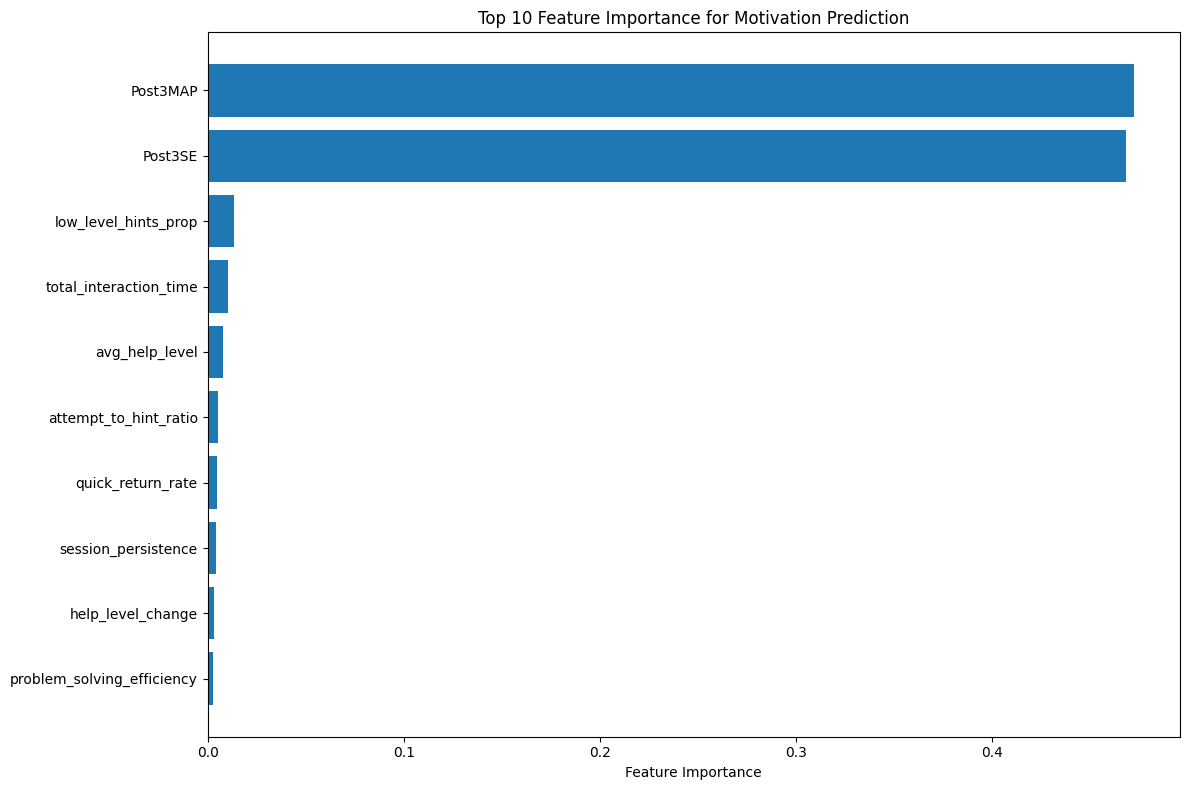


💾 Feature importance saved to motivation_feature_importance.csv

 MAP-RELATED FEATURE IMPORTANCE:
                         feature  importance
4              help_level_change    0.003095
3             hint_usage_pattern    0.002715
1             problems_attempted    0.001472
0  sessions_balanced_by_problems    0.000760
5           step_completion_rate    0.000564
2       graduated_workspaces_pct    0.000000

 SE-RELATED FEATURE IMPORTANCE:
                  feature  importance
9    low_level_hints_prop    0.013295
8          avg_help_level    0.007697
6   attempt_to_hint_ratio    0.005445
7       quick_return_rate    0.004841
10  high_level_hints_prop    0.002206

MAP features total importance: 0.009
SE features total importance: 0.033


In [25]:
# ==============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ==============================================================================

print("\n📊 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importance for Motivation Prediction')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Save feature importance
    feature_importance.to_csv('motivation_feature_importance.csv', index=False)
    print("\n💾 Feature importance saved to motivation_feature_importance.csv")
    
    # Separate MAP vs SE feature importance
    map_feature_names = [
        'sessions_balanced_by_problems', 'problems_attempted', 'graduated_workspaces_pct',
        'hint_usage_pattern', 'help_level_change', 'step_completion_rate'
    ]
    se_feature_names = [
        'attempt_to_hint_ratio', 'quick_return_rate', 'avg_help_level',
        'low_level_hints_prop', 'high_level_hints_prop'
    ]
    
    map_importance = feature_importance[feature_importance['feature'].isin(map_feature_names)]
    se_importance = feature_importance[feature_importance['feature'].isin(se_feature_names)]
    
    print(f"\n MAP-RELATED FEATURE IMPORTANCE:")
    print(map_importance)
    
    print(f"\n SE-RELATED FEATURE IMPORTANCE:")
    print(se_importance)
    
    print(f"\nMAP features total importance: {map_importance['importance'].sum():.3f}")
    print(f"SE features total importance: {se_importance['importance'].sum():.3f}")


In [26]:
# ==============================================================================
# FINAL SUMMARY - MOTIVATION CLASSIFICATION MODEL
# ==============================================================================

print(f"\nMOTIVATION CLASSIFICATION MODEL SUMMARY")
print("=" * 60)
print(f"Dataset: {len(df)} students with behavioral features")
print(f"Target: Motivation scores (Average of PostSE and PostMAP)")
print(f"Features: {len(feature_cols)} MAP and SE specific behavioral features")
print(f"Best Model: {type(best_model).__name__}")
print(f"Test QWK Score: {test_qwk:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"\nMotivation = (PostSE + PostMAP) / 2")
print(f"Model optimized for QWK metric - suitable for ordinal classification!")

# Component analysis
print(f"\n📈 COMPONENT ANALYSIS:")
postse_mean = df['Post3SE'].mean()
postmap_mean = df['Post3MAP'].mean()
correlation = df['Post3SE'].corr(df['Post3MAP'])

print(f"PostSE mean: {postse_mean:.3f}")
print(f"PostMAP mean: {postmap_mean:.3f}")
print(f"PostSE-PostMAP correlation: {correlation:.3f}")



MOTIVATION CLASSIFICATION MODEL SUMMARY
Dataset: 539 students with behavioral features
Target: Motivation scores (Average of PostSE and PostMAP)
Features: 16 MAP and SE specific behavioral features
Best Model: GradientBoostingClassifier
Test QWK Score: 0.961
Test Accuracy: 0.880

Motivation = (PostSE + PostMAP) / 2
Model optimized for QWK metric - suitable for ordinal classification!

📈 COMPONENT ANALYSIS:
PostSE mean: 4.788
PostMAP mean: 4.830
PostSE-PostMAP correlation: 0.791


# Run Model on Test Dataset

In [ ]:
# ==============================================================================
# LOAD TEST DATASETS
# ==============================================================================

test_main = pd.read_csv('path/to/cleaned/test_df_main.csv')  # Replace with path to test time series dataset
test_ws = pd.read_csv('path/to/cleaned/test_ws_dataset.csv')  # Replace with path to test workspace dataset
test_cleaned_map = pd.read_csv('path/to/cleaned/test_cleaned_map.csv')  # Replace with path to test MAP dataset
test_cleaned_se = pd.read_csv('path/to/cleaned/test_cleaned_se.csv')  # Replace with path to test SE dataset

In [ ]:
# ==============================================================================
# VALIDATE TEST DATA
# ==============================================================================

print(f"✓ Test main interaction data: {len(test_main):,} records")
print(f"✓ Test workspace data: {len(test_ws):,} workspace sessions")
print(f"✓ Test MAP assessments: {len(test_cleaned_map):,} students")
print(f"✓ Test SE assessments: {len(test_cleaned_se):,} students")

print(f"\nVALIDATING TEST MOTIVATION DATA:")
print("-" * 40)
print("Test MAP columns:", test_cleaned_map.columns.tolist())
print("Test SE columns:", test_cleaned_se.columns.tolist())

# Check for Post3SE and Post3MAP specifically
missing_cols = []

if 'Post3MAP' not in test_cleaned_map.columns:
    missing_cols.append('Post3MAP')
if 'Post3SE' not in test_cleaned_se.columns:
    missing_cols.append('Post3SE')

if missing_cols:
    print(f"ERROR: Missing columns: {missing_cols}")
    print("Available Test MAP columns:", test_cleaned_map.columns.tolist())
    print("Available Test SE columns:", test_cleaned_se.columns.tolist())
else:
    print("Post3MAP found in Test MAP data")
    non_null_count_map = test_cleaned_map['Post3MAP'].notna().sum()
    col_range_map = f"{test_cleaned_map['Post3MAP'].min():.2f} to {test_cleaned_map['Post3MAP'].max():.2f}"
    print(f"  - Non-null values: {non_null_count_map}, Range: {col_range_map}")
    
    print("Post3SE found in Test SE data")
    non_null_count_se = test_cleaned_se['Post3SE'].notna().sum()
    col_range_se = f"{test_cleaned_se['Post3SE'].min():.2f} to {test_cleaned_se['Post3SE'].max():.2f}"
    print(f"  - Non-null values: {non_null_count_se}, Range: {col_range_se}")

In [ ]:
# ==============================================================================
# CREATE TEST TARGET VARIABLES
# ==============================================================================

print("\nCREATING TEST MOTIVATION TARGET VARIABLE")
print("=" * 50)

# Merge the two test datasets on student ID
test_df_combined = test_cleaned_se.merge(test_cleaned_map, on='Anon.Student.Id', how='inner')

# Filter students with both Post3SE and Post3MAP scores
test_motivation_data = test_df_combined[
    test_df_combined['Post3SE'].notna() & 
    test_df_combined['Post3MAP'].notna()
].copy()

print(f"Test students with both Post3SE and Post3MAP scores: {len(test_motivation_data)}")

# Create motivation score as average of Post3SE and Post3MAP
test_motivation_data['motivation_score'] = (test_motivation_data['Post3SE'] + test_motivation_data['Post3MAP']) / 2

# Create categorical version (Low, Medium, High)
test_motivation_data['motivation_category'] = test_motivation_data['motivation_score'].apply(categorize_motivation)

# Show distribution
print(f"\nTest motivation score statistics:")
print(f"  Mean: {test_motivation_data['motivation_score'].mean():.2f}")
print(f"  Std: {test_motivation_data['motivation_score'].std():.2f}")
print(f"  Range: {test_motivation_data['motivation_score'].min():.2f} - {test_motivation_data['motivation_score'].max():.2f}")

category_counts = test_motivation_data['motivation_category'].value_counts()
print(f"\nTest motivation category distribution:")
for category, count in category_counts.items():
    percentage = (count / len(test_motivation_data)) * 100
    print(f"  • {category}: {count} students ({percentage:.1f}%)")

print(f"\nTest target variable created successfully!")

In [ ]:
# ==============================================================================
# ENGINEER TEST FEATURES
# ==============================================================================

print("\n🔧 ENGINEERING TEST FEATURES")
print("=" * 50)

# Get students with motivation scores
test_target_students = test_motivation_data['Anon.Student.Id'].unique()
test_df_filtered = test_main[test_main['Anon.Student.Id'].isin(test_target_students)].copy()
test_df_ws_filtered = test_ws[test_ws['Anon.Student.Id'].isin(test_target_students)].copy()

print(f"Test students: {len(test_target_students)}")
print(f"Test behavioral data: {len(test_df_filtered):,} interactions")
print(f"Test workspace data: {len(test_df_ws_filtered):,} workspace sessions")

# Feature engineering by student
test_features_list = []

for student_id in test_target_students:
    student_data = test_df_filtered[test_df_filtered['Anon.Student.Id'] == student_id].copy()
    student_ws = test_df_ws_filtered[test_df_ws_filtered['Anon.Student.Id'] == student_id].copy()
    
    if len(student_data) == 0:
        continue
    
    features = {'Anon.Student.Id': student_id}
    
    # ==========================================================================
    # MAP-RELATED FEATURES (Mastery-Oriented Behavior)
    # ==========================================================================
    
    # 1. Sessions per Student, balanced by average problems solved per session
    unique_sessions = student_data['Session.Id'].nunique()
    total_problems = student_data['Problem.Name'].nunique()
    avg_problems_per_session = total_problems / unique_sessions if unique_sessions > 0 else 0
    features['sessions_balanced_by_problems'] = unique_sessions * (avg_problems_per_session / 10)  # Normalize
    
    # 2. Number of Problems Attempted
    features['problems_attempted'] = total_problems
    
    # 3. Percentage of Graduated Workspaces
    if len(student_ws) > 0:
        graduated_ws = student_ws['Graduate'].sum() if 'Graduate' in student_ws.columns else 0
        total_ws = len(student_ws)
        features['graduated_workspaces_pct'] = graduated_ws / total_ws if total_ws > 0 else 0
    else:
        features['graduated_workspaces_pct'] = 0
    
    # 4. Hint Usage Pattern (strategic use of hints)
    hint_followed_by_success = 0
    total_hint_instances = 0
    
    for problem in student_data['Problem.Name'].unique():
        problem_data = student_data[student_data['Problem.Name'] == problem].sort_values('time_step')
        
        for i in range(len(problem_data) - 1):
            current_action = str(problem_data.iloc[i]['Action']).lower()
            next_outcome = str(problem_data.iloc[i + 1]['Outcome']).upper()
            
            if 'hint' in current_action:
                total_hint_instances += 1
                if next_outcome in ['OK', 'CORRECT']:
                    hint_followed_by_success += 1
    
    features['hint_usage_pattern'] = hint_followed_by_success / total_hint_instances if total_hint_instances > 0 else 0
    
    # 5. Change in Help Level Over Time (learning progression)
    if 'Help.Level' in student_data.columns:
        help_levels = student_data['Help.Level'].dropna()
        if len(help_levels) > 1:
            # Calculate trend: negative means decreasing help needs over time
            x = np.arange(len(help_levels))
            slope = np.polyfit(x, help_levels, 1)[0]
            features['help_level_change'] = -slope  # Negative slope is good (less help over time)
        else:
            features['help_level_change'] = 0
    else:
        features['help_level_change'] = 0
    
    # 6. Step Completion Rate
    completed_steps = student_data['Outcome'].isin(['OK', 'CORRECT']).sum()
    total_steps = len(student_data)
    features['step_completion_rate'] = completed_steps / total_steps if total_steps > 0 else 0
    
    # ==========================================================================
    # SE-RELATED FEATURES (Self-Efficacy)
    # ==========================================================================
    
    # 7. Ratio of Attempts to Hint Requests
    attempt_actions = student_data['Action'].str.contains('attempt|submit', case=False, na=False).sum()
    hint_actions = student_data['Action'].str.contains('hint', case=False, na=False).sum()
    features['attempt_to_hint_ratio'] = attempt_actions / hint_actions if hint_actions > 0 else attempt_actions
    
    # 8. Quick Return After Error (resilience)
    quick_returns = 0
    error_instances = 0
    
    for i in range(len(student_data) - 1):
        if student_data.iloc[i]['Outcome'] in ['ERROR', 'WRONG']:
            error_instances += 1
            time_diff = student_data.iloc[i + 1]['time_step'] - student_data.iloc[i]['time_step']
            if time_diff < 30:  # Quick return within 30 seconds
                quick_returns += 1
    
    features['quick_return_rate'] = quick_returns / error_instances if error_instances > 0 else 1
    
    # 9. Average Help Level (lower = more self-efficacy)
    if 'Help.Level' in student_data.columns:
        help_levels = student_data['Help.Level'].dropna()
        help_levels_nonzero = help_levels[help_levels > 0]
        features['avg_help_level'] = help_levels_nonzero.mean() if len(help_levels_nonzero) > 0 else 0
    else:
        features['avg_help_level'] = 0
    
    # 10. Proportion of Low-Level Hints (SE indicator)
    if 'Help.Level' in student_data.columns:
        hint_requests = student_data[student_data['Action'].str.contains('hint', case=False, na=False)]
        if len(hint_requests) > 0:
            low_level_hints = hint_requests['Help.Level'].isin([0, 1]).sum()
            features['low_level_hints_prop'] = low_level_hints / len(hint_requests)
        else:
            features['low_level_hints_prop'] = 0
    else:
        features['low_level_hints_prop'] = 0
    
    # 11. Proportion of High-Level Hints (lower SE indicator)
    if 'Help.Level' in student_data.columns:
        hint_requests = student_data[student_data['Action'].str.contains('hint', case=False, na=False)]
        if len(hint_requests) > 0:
            high_level_hints = hint_requests['Help.Level'].isin([4, 5]).sum()
            features['high_level_hints_prop'] = high_level_hints / len(hint_requests)
        else:
            features['high_level_hints_prop'] = 0
    else:
        features['high_level_hints_prop'] = 0
    
    # ==========================================================================
    # ADDITIONAL MOTIVATION-RELATED FEATURES
    # ==========================================================================
    
    # 12. Session Persistence
    features['session_persistence'] = unique_sessions
    
    # 13. Total Interaction Time
    if len(student_data) > 1:
        features['total_interaction_time'] = student_data['time_step'].max() - student_data['time_step'].min()
    else:
        features['total_interaction_time'] = 0
    
    # 14. Problem-solving Efficiency
    avg_time_per_problem = features['total_interaction_time'] / total_problems if total_problems > 0 else 0
    features['problem_solving_efficiency'] = 1 / (1 + avg_time_per_problem / 60)  # Normalize to minutes
    
    test_features_list.append(features)

# Create test features dataframe
test_features_df = pd.DataFrame(test_features_list)
print(f"\nTest features engineered for {len(test_features_df)} students")
print(f"Total features: {len(test_features_df.columns) - 1}")

print("\n🎯 MAP-FOCUSED FEATURES:")
print("-" * 30)
map_features = [
    'sessions_balanced_by_problems', 'problems_attempted', 'graduated_workspaces_pct',
    'hint_usage_pattern', 'help_level_change', 'step_completion_rate'
]

for feat in map_features:
    if feat in test_features_df.columns:
        mean_val = test_features_df[feat].mean()
        print(f"  ✓ {feat}: mean = {mean_val:.3f}")

print("\n🎯 SE-FOCUSED FEATURES:")
print("-" * 30)
se_features = [
    'attempt_to_hint_ratio', 'quick_return_rate', 'avg_help_level',
    'low_level_hints_prop', 'high_level_hints_prop'
]

for feat in se_features:
    if feat in test_features_df.columns:
        mean_val = test_features_df[feat].mean()
        print(f"  ✓ {feat}: mean = {mean_val:.3f}")

# Display feature statistics
print(f"\nTest feature summary:")
print(test_features_df.describe().round(3))

In [ ]:
# ==============================================================================
# PREPARE TEST DATA
# ==============================================================================

# Merge test features with motivation scores (including Post3SE and Post3MAP as features)
test_df = test_features_df.merge(
    test_motivation_data[['Anon.Student.Id', 'motivation_score', 'motivation_category', 'Post3SE', 'Post3MAP']], 
    on='Anon.Student.Id', how='inner'
)

print(f"Final test dataset: {len(test_df)} students")

# Handle missing values using same imputer as training
test_numerical_cols = test_df.select_dtypes(include=[np.number]).columns
test_numerical_cols = [col for col in test_numerical_cols if col not in ['motivation_score', 'Post3SE', 'Post3MAP']]

test_df[test_numerical_cols] = imputer.transform(test_df[test_numerical_cols])

print(f"Test data preparation complete!")
print(f"Test shape: {test_df.shape}")

In [ ]:
# ==============================================================================
# FINAL TEST PREDICTIONS
# ==============================================================================

test_X = test_df[feature_cols]
test_y_true = test_df['motivation_score'].round().astype(int)

test_predictions = best_model.predict(test_X)

# Calculate final performance metrics
final_accuracy = accuracy_score(test_y_true, test_predictions)
final_qwk = cohen_kappa_score(test_y_true, test_predictions, weights='quadratic')

print(f"\nFINAL TEST RESULTS:")
print(f"Test Students: {len(test_df)}")
print(f"Test Accuracy: {final_accuracy:.3f}")
print(f"Test QWK: {final_qwk:.3f}")

# Component-wise analysis
print(f"\nCOMPONENT ANALYSIS:")
test_postse_mean = test_df['Post3SE'].mean()
test_postmap_mean = test_df['Post3MAP'].mean()
test_correlation = test_df['Post3SE'].corr(test_df['Post3MAP'])

print(f"Test Post3SE mean: {test_postse_mean:.3f}")
print(f"Test Post3MAP mean: {test_postmap_mean:.3f}")
print(f"Test Post3SE-Post3MAP correlation: {test_correlation:.3f}")

# Optional: Save predictions
test_results = test_df[['Anon.Student.Id']].copy()
test_results['True_Motivation'] = test_y_true
test_results['Predicted_Motivation'] = test_predictions
test_results['True_Post3SE'] = test_df['Post3SE']
test_results['True_Post3MAP'] = test_df['Post3MAP']
test_results.to_csv('motivation_test_predictions.csv', index=False)
print(f"\nPredictions saved to motivation_test_predictions.csv")

print(f"\nMOTIVATION MODEL EVALUATION COMPLETE!")